# DESI spectral extraction code benchmarks #

Stephen Bailey<br/>
Lawrence Berkeley National Lab<br/>
Spring 2017

## Update 2017-03-12 ##

Intel engineers identified the cause of the previous lack of scaling with number of processes (an OpenMP bug on KNL).  The work-around is:
  * for multiprocessing, use `$KMP_AFFINITY=disabled`
  * for MPI, use `srun --cpu_bind=cores ...`
  * On Haswell, neither of these is necessary to achieve reasonable scaling

## Introduction ##

These benchmarks test the DESI spectral extraction code, which is the most computationally
intensive portion of our data processing pipeline.  It performs a forward modeling analysis
of astronomical spectra projected onto 2D CCD images.  Early non-KNL benchmarking indicated
that it was spending approximately 1/3 of its time in each of
  * MKL via `scipy.linalg.eigh`
  * Miscellaneous non-MKL compiled code in `numpy` and `scipy`
  * Miscellaneous pure python

We have not recently re-benchmarked this code and these benchmarks use a smaller example problem that may have a different ratio.

See the end of this notebook for how to get the code and run the benchmarks.

## Scaling with \$OMP_NUM_THREADS ##

Initial test: check if `$OMP_NUM_THREADS` matters for this code.  Takeaway points:
  * `$OMP_NUM_THREADS` doesn't matter for this code, presumably because it is spending
    most of its time in non-MKL / non-OpenMP code.
  * single process Haswell ~6x faster than single-process KNL

example srun commands:
```
#- Haswell
srun -n 1 -c 64 --cpu_bind=cores python extract.py 1 4 16 32 64

#- KNL
srun -n 1 -c 256 --cpu_bind=cores python extract.py 1 4 16 64 256
```
On Haswell, no significant effect from setting or not
  * OMP_PROC_BIND=spread
  * OMP_PLACES=cores
  * KMP_AFFINITY=disabled

The remaining tests use `$OMP_NUM_THREADS=1`

In [1]:
%pylab inline
import numpy as np
from astropy.table import Table

Populating the interactive namespace from numpy and matplotlib


ratio = 6.4


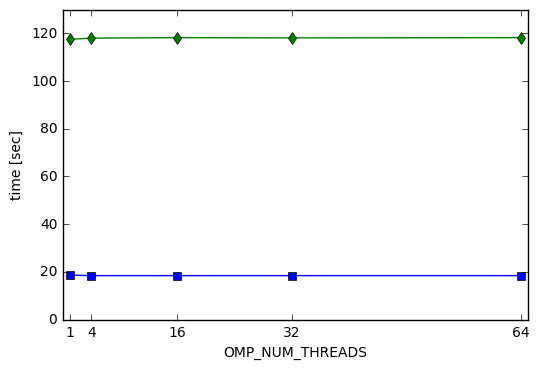

In [2]:
#- Scaling with OMP_NUM_THREADS (or not)
nt_hsw = Table.read('data/extract/ex-nthread-hsw-1.dat', format='ascii')
nt_knl = Table.read('data/extract/ex-nthread-knl-1.dat', format='ascii')

plot(nt_hsw['OMP_NUM_THREADS'], nt_hsw['time'], 'bs-')
plot(nt_knl['OMP_NUM_THREADS'], nt_knl['time'], 'gd-')
xlabel('OMP_NUM_THREADS'); ylabel('time [sec]')
xticks(nt_hsw['OMP_NUM_THREADS'], nt_hsw['OMP_NUM_THREADS'])
xlim(0,65); ylim(0,130)
ratio = np.max(nt_knl['time']) / np.max(nt_hsw['time'])
print('ratio = {:.1f}'.format(ratio))

## Scaling tests ##

Test the single node scaling performance for Haswell and KNL with two methods:
  * python multiprocessing
  * mpi4py
    
This is a data-parallel problem where different processes/ranks
are working on different pieces of data without needing to communicate
with each other.  Under ideal scaling each iteration
will take the same amount of well time such that more processes = more data processed
= higher total rate.  Takeaway points:

* Scaling is quite good up to the number of physical cores, with slight degredation
  after that on Haswell and slight gains on KNL.
* A Haswell nodes is 2-3x faster than a KNL node
* Not shown here:
  * On Haswell, not setting `$OMP_NUM_THREADS=1` clobbers performance at larger concurrency,
    even though the previous test indicated that `$OMP_NUM_THREADS > 1` doesn't help for
    a single process.

In [3]:
#- Scaling with OMP_NUM_THREADS (or not)
hsw_mpi = Table.read('data/extract/exmpi-hsw-2.dat', format='ascii')
knl_mpi = Table.read('data/extract/exmpi-knl-2.dat', format='ascii')
hsw_mp  = Table.read('data/extract/exmp-hsw-2.dat', format='ascii')
knl_mp  = Table.read('data/extract/exmp-knl-2.dat', format='ascii')

ratio of Haswell/KNL node rate = 3.4
ratio of Haswell/KNL process rate = 8.4


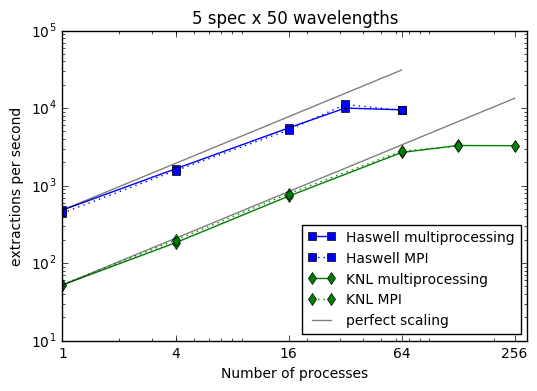

In [4]:
rcParams['legend.fontsize'] = 10
plot(hsw_mp['nproc'],  hsw_mp['rate'],  'bs-', label='Haswell multiprocessing')
plot(hsw_mpi['nproc'], hsw_mpi['rate'], 'bs:', label='Haswell MPI')
plot(knl_mp['nproc'],  knl_mp['rate'],  'gd-', label='KNL multiprocessing')
plot(knl_mpi['nproc'], knl_mpi['rate'], 'gd:', label='KNL MPI')
x = hsw_mp['nproc']
plot(x, hsw_mp['rate'][0]*x/x[0], 'k-', alpha=0.5, label='perfect scaling')
x = knl_mp['nproc']
plot(x, knl_mp['rate'][0]*x/x[0], 'k-', alpha=0.5, label='_none_')

legend(loc='lower right')
xlabel('Number of processes'); ylabel('extractions per second')
loglog()
xlim(1,300)
xticks([1,4,16,64,256], [1,4,16,64,256])
title('5 spec x 50 wavelengths')

maxhsw = max(np.max(hsw_mp['rate']), np.max(hsw_mpi['rate']))
maxknl = max(np.max(knl_mp['rate']), np.max(knl_mpi['rate']))
print('ratio of Haswell/KNL node rate = {:.1f}'.format(maxhsw/maxknl))
print('ratio of Haswell/KNL process rate = {:.1f}'.format(hsw_mpi['rate'][0]/knl_mpi['rate'][0]))
# savefig('extract-scaling.png')

In [5]:
#- Scaling with larger extraction size (more realistic for how DESI currently runs)
hsw = Table.read('data/extract/exmp-hsw-3.dat', format='ascii')
knl = Table.read('data/extract/exmp-knl-3.dat', format='ascii')

HSW/KNL = 1.8529674537332481


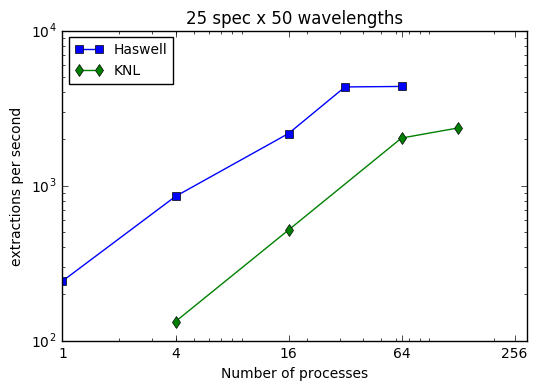

In [6]:
plot(hsw['nproc'], hsw['rate'], 'bs-', label='Haswell')
plot(knl['nproc'], knl['rate'], 'gd-', label='KNL')
loglog()
legend(loc='upper left')
xlabel('Number of processes')
ylabel('extractions per second')
xticks([1,4,16,64,256], [1,4,16,64,256])
xlim(1,300)
title('25 spec x 50 wavelengths')

print('HSW/KNL = {}'.format(np.max(hsw['rate'])/np.max(knl['rate'])))

## Startup time ##

Python startup time was significant for N>>1 MPI processes, especially on KNL.  All code was installed to `$SCRATCH` or /global/common (fast metadata disks) and `$PYTHONPATH` did not have anything in /home or /project (slow metadata disks).  "Wakeup" timed the following imports:
```python
from mpi4py import MPI
comm = MPI.COMM_WORLD

import sys, os
import platform
import optparse
import multiprocessing
import numpy as np
from specter.extract import ex2d
import specter.psf
import knltest
```

([<matplotlib.axis.XTick at 0x2b8d13c57550>,
 <a list of 4 Text xticklabel objects>)

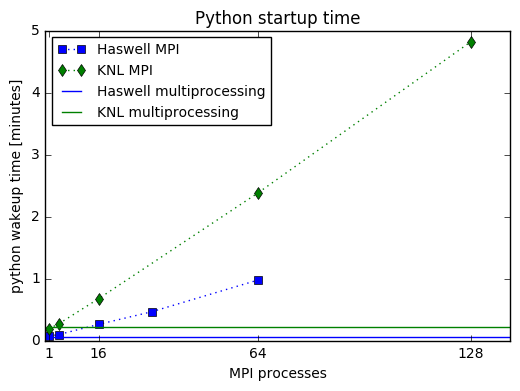

In [7]:
plot(hsw_mpi['nproc'], hsw_mpi['wakeup']/60, 'bs:', label='Haswell MPI')
plot(knl_mpi['nproc'], knl_mpi['wakeup']/60, 'gd:', label='KNL MPI')
axhline(3.5/60, color='b', label='Haswell multiprocessing')
axhline(12.8/60, color='g', label='KNL multiprocessing')
ylabel('python wakeup time [minutes]')
xlabel('MPI processes')
legend(loc='upper left')
title('Python startup time')
xticks([1,16,64,128], [1,16,64,128])

# Setup to reproduce these results #

### Create a basic python environment ###
Start with an IDP or Anaconda distribution with numpy, scipy, astropy (and possibly others...), e.g.

```bash
conda create -n knltest python=3.5 numpy scipy astropy
source activate knltest
```

### Get the benchmark code ###

```bash
git clone https://github.com/sbailey/knltest
git clone https://github.com/desihub/specter

#- reference versions used for these tests
cd knltest; git checkout 065f961; cd ..
cd specter; git checkout 391ac23; cd ..

export PYTHONPATH=`pwd`/specter/py:$PYTHONPATH
cd knltest/code
export OMP_NUM_THREADS=1
export KMP_AFFINITY=disabled
```

Note: you can also run `python setup.py install` in the `specter/` directory to do a normal python package installation.  The above `$PYTHONPATH` trick is the minimally invasive option.

### Run multiprocessing benchmark locally ###
This will run the extraction code with 1, 4, 16... parallel processes, where each
process is given the same amount of work to do.

```bash
python extract-mp.py 1 4 16 32 64 --bundlesize 5 --numwave 50
python extract-mp.py 1 4 16 64 128 256 --bundlesize 5 --numwave 50
python extract-mp.py 4 16 64 128 256 --bundlesize 25 --numwave 50

```

There is also an mpi4py version of this test which uses MPI ranks instead of multiprocessing processes.  In that case it will only use as many ranks as are specified in the options to `extract-mpi.py`.

### MPI: run with SLURM to a compute node ###
Allocate just the number of MPI processes needed for the test
```bash
#- KNL
for n in 1 4 16 64 128 256; do
    let c=256/$n
    srun -n $n -c $c --cpu_bind=cores python extract-mpi.py $n --bundlesize 5 --numwave 50
done

#- Haswell
for n in 1 4 16 32 64; do
    let c=64/$n
    srun -n $n -c $c --cpu_bind=cores python extract-mpi.py $n --bundlesize 5 --numwave 50
done

#- For comparison: allocate 16 ranks but use fewer of them, leaving others idle
#- This hurts MPI scaling performance and is *not* what was shown above
srun -n 16 -c 1 --cpu_bind=cores python extract-mpi.py 1 4 16 --bundlesize 5 --numwave 50
```

## Stephen's setup on Cori ##

```
module load python/3.5-anaconda
cd $SCRATCH/desi/knlcode/
export PYTHONPATH=`pwd`/specter/py:$PYTHONPATH
cd knltest/code
```